In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D,BatchNormalization, LSTM, CuDNNLSTM, MaxPooling2D
from keras.models import Sequential
from keras import regularizers
import keras

from keras.layers import TimeDistributed
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import matplotlib.pyplot as plt
import cv2

In [2]:
image_generator = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=2, 
    vertical_flip=2
)    

training_set = image_generator.flow_from_directory(batch_size=256,
                                                 directory='./facial_expression/train/',
                                                 shuffle=True,
                                                 target_size=(48, 48), 
                                                 class_mode='categorical',
#                                                  color_mode = "grayscale"
                                                )

testing_set = image_generator.flow_from_directory(batch_size=128,
                                                 directory='./facial_expression/test/',
                                                 shuffle=True,
                                                 target_size=(48, 48), 
                                                 class_mode='categorical',
#                                                  color_mode = "grayscale"
                                                 )

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [3]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [4]:
model = VGG19(
      input_shape = (48, 48, 3),
      include_top = False,
      weights = 'imagenet'
    )

In [5]:
for layers in model.layers:
    layers.trainable = False

In [6]:
x = Flatten()(model.output)
x = Dense(512, activation = "relu")(x)
x = Dropout(0.5)(x)
x = Dense(14, activation = "relu")(x)
x = Dense(7, activation = "softmax")(x)

model = keras.Model(model.input, x)
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = "accuracy")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [7]:
hist = model.fit_generator(training_set, validation_data = testing_set , epochs = 5)

Epoch 1/5


C:\Users\Administrator\AppData\Local\Temp\ipykernel_7660\3028496548.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(training_set, validation_data = testing_set , epochs = 5)


113/113 [==============================] - 682s 6s/step - loss: 1.7552 - accuracy: 0.2860 - val_loss: 1.6519 - val_accuracy: 0.3444
Epoch 2/5
113/113 [==============================] - 654s 6s/step - loss: 1.6596 - accuracy: 0.3407 - val_loss: 1.6135 - val_accuracy: 0.3679
Epoch 3/5
113/113 [==============================] - 650s 6s/step - loss: 1.6373 - accuracy: 0.3550 - val_loss: 1.6052 - val_accuracy: 0.3661
Epoch 4/5
113/113 [==============================] - 653s 6s/step - loss: 1.6176 - accuracy: 0.3640 - val_loss: 1.5883 - val_accuracy: 0.3755
Epoch 5/5
113/113 [==============================] - 676s 6s/step - loss: 1.6093 - accuracy: 0.3697 - val_loss: 1.5903 - val_accuracy: 0.3761


In [8]:
hist = hist.history

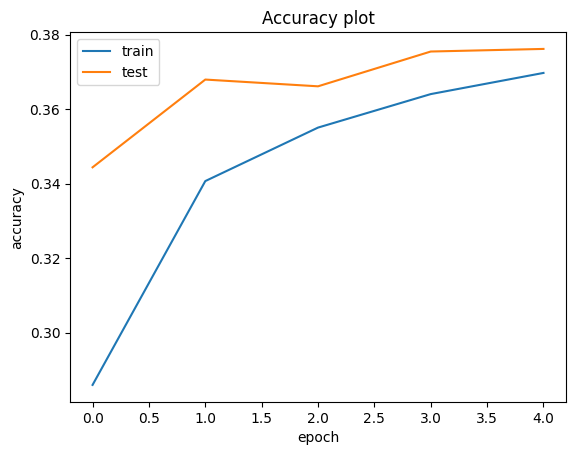

In [9]:
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("vgg19v2_accuracy.png")

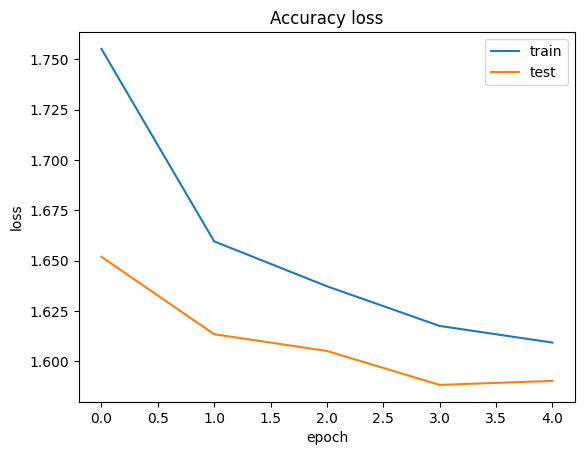

In [10]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("vgg19v2_loss.png")

In [11]:
model.save("vgg19v2.h5")

In [12]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,3)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = "adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [13]:
hist = model.fit_generator(training_set, validation_data = testing_set , epochs = 5)

Epoch 1/5


C:\Users\Administrator\AppData\Local\Temp\ipykernel_7660\3028496548.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(training_set, validation_data = testing_set , epochs = 5)


113/113 [==============================] - 1032s 9s/step - loss: 7.0806 - accuracy: 0.2084 - val_loss: 4.7689 - val_accuracy: 0.1719
Epoch 2/5
113/113 [==============================] - 1057s 9s/step - loss: 2.9717 - accuracy: 0.2607 - val_loss: 2.7085 - val_accuracy: 0.2471
Epoch 3/5
 19/113 [====>.........................] - ETA: 14:10 - loss: 2.5102 - accuracy: 0.2973

In [ ]:
hist = hist.history

In [ ]:
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("CNNv2_accuracy.png")

In [ ]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("CNNv2_loss.png")

In [ ]:
model.save("CNNv2.h5")

In [ ]:
# Initialize image data generator with rescaling
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all test images
train_generator = train_data_gen.flow_from_directory(
        '../input/fer2013/train',
        target_size=(48, 48),
        batch_size=64,
#         color_mode="grayscale",
        class_mode='categorical')

# Preprocess all train images
validation_generator = validation_data_gen.flow_from_directory(
        '../input/fer2013/test',
        target_size=(48, 48),
        batch_size=64,
#         color_mode="grayscale",
        class_mode='categorical')

In [ ]:
dim = (48,48) # for MobileNetV2
n_sequence = 8 # for LSTM
n_channels = 3 # color channel(RGB)
n_output = 7 #18 # number of output class

In [ ]:
model = Sequential()    
model.add(tf.keras.layers.Reshape((1, 48, 48, 3), input_shape=(48, 48, 3)))
model.add( 
    TimeDistributed(
        MobileNetV2(weights='imagenet',include_top=False), 
        input_shape=(n_sequence, *dim, n_channels)
    )
)
model.add(
    TimeDistributed(
        GlobalAveragePooling2D()
    )
)
model.add(CuDNNLSTM(64, return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(24, activation='relu'))
model.add(Dropout(.5))  
model.add(Dense(n_output, activation='softmax'))

# model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# opt = Adam(lr=0.0001)
model.compile(optimizer = "adam",loss = "categorical_crossentropy" , metrics=['accuracy'])
# model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# hist = model.fit_generator(train_generator, validation_data = validation_generator , epochs = 20)
hist = model.fit_generator(training_set, validation_data = testing_set , epochs = 25)

In [ ]:
hist = hist.history
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("mobilenetCuDNNLSTMv3_accuracy.png")

In [ ]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("mobilenetCuDNNLSTMv3_loss.png")


In [ ]:
model.save("mobilenetCuDNNLSTMv3.h5")

In [ ]:
model = Sequential()    
model.add(tf.keras.layers.Reshape((1, 48, 48, 3), input_shape=(48, 48, 3)))
model.add( 
    TimeDistributed(
        MobileNetV2(weights='imagenet',include_top=False), 
        input_shape=(n_sequence, *dim, n_channels)
    )
)
model.add(
    TimeDistributed(
        GlobalAveragePooling2D()
    )
)
model.add(CuDNNLSTM(128,return_sequences = True))
model.add(Dropout(0.2))

model.add(CuDNNLSTM(128))
model.add(Dropout(0.2))

model.add(Dense(32,activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(7,activation = 'softmax'))

# opt = tf.keras.optimizers.Adam(lr = 1e-3,decay = 1e-5)
# model.compile(optimizer = opt,loss = "categorical_crossentropy" , metrics=['accuracy'])

# model.add(CuDNNLSTM(64, return_sequences=False))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(.5))
# model.add(Dense(24, activation='relu'))
# model.add(Dropout(.5))  
# model.add(Dense(n_output, activation='softmax'))

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
hist = model.fit_generator(train_generator, validation_data = validation_generator , epochs = 20)
hist = hist.history

In [ ]:
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("mobilenetCuDNNLSTMv2_accuracy.png")

In [ ]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("mobilenetCuDNNLSTMv2_loss.png")

In [ ]:
model.save("mobilenetCuDNNLSTMv2.h5")

In [ ]:
# create model structure
emotion_model = Sequential()

emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 3)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation='softmax'))

cv2.ocl.setUseOpenCL(False)

emotion_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-6), metrics=['accuracy'])

# Train the neural network/model
emotion_model_info = emotion_model.fit_generator(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=7178 // 64)

# save trained model weight in .h5 file
emotion_model.save('emotion_model.h5')

In [ ]:
hist = emotion_model_info.history

In [ ]:
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("emotion_model_accuracy.png")

In [ ]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("emotion_model_loss.png")


In [ ]:
model = Sequential()    
model.add(tf.keras.layers.Reshape((1, 48, 48, 3), input_shape=(48, 48, 3)))
model.add( 
    TimeDistributed(
        MobileNetV2(weights='imagenet',include_top=False), 
        input_shape=(n_sequence, *dim, n_channels)
    )
)
model.add(
    TimeDistributed(
        GlobalAveragePooling2D()
    )
)
model.add(CuDNNLSTM(128,return_sequences = True))
model.add(Dropout(0.2))

model.add(CuDNNLSTM(128))
model.add(Dropout(0.2))

model.add(Dense(32,activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(7,activation = 'softmax'))

cv2.ocl.setUseOpenCL(False)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-6), metrics=['accuracy'])

# Train the neural network/model
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=7178 // 64)


In [ ]:
hist = hist.history

In [ ]:
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("mobilenetCuDNNLSTMv4_accuracy.png")

In [ ]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("mobilenetCuDNNLSTMv4_loss.png")

In [ ]:
model.save("mobilenetCuDNNLSTMv4.h5")